In [1]:
#pip install numpy pandas scikit-learn xgboost shap matplotlib

In [17]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.stats import spearmanr



data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# PCA is sensitive to feature scales because it prioritizes directions of maximum variance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# looking at percent of missing values by column
print(X.describe)
#missing = X.isna().sum()/len(X) * 100
#missing

#Malignant =1 , Benign = 0

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0           

## PCA Visualization

In [4]:

print("\n---- PCA Dimensionality Reduction ---")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)


components_ = pca.components_
feature_names = data.feature_names
#dataframe that describes how each feature contributes to the Principal Components
pca_components_df = pd.DataFrame(components_,columns=feature_names,index = ['PC1','PC2'])

print("\n Principal Components: ")
print(pca_components_df.T.sort_values(by="PC1",ascending=False).head(5))

# Explained Variance
print("\nExplained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance:", sum(pca.explained_variance_ratio_))

# a high positive value means that increasing this feature increases the component's value
# a negative value means that increasing this feature decresases the corresponding principal component's value
#samples with a high "worst perimeter" would tend to have low PC2 values


---- PCA Dimensionality Reduction ---

 Principal Components: 
                           PC1       PC2
mean concave points   0.263324 -0.039640
mean concavity        0.259500  0.064037
worst concave points  0.252917 -0.005671
mean compactness      0.240836  0.150134
worst perimeter       0.236126 -0.203586

Explained Variance Ratio: [0.43502782 0.19500007]
Total Explained Variance: 0.6300278846854036


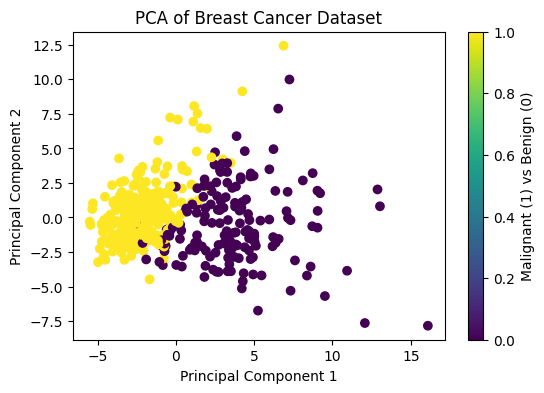

In [5]:
# Together PC1 and PC2 explain 63% of the total variance in the dataset
# We can visualize the pca dimension reduced dataset

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Breast Cancer Dataset')
plt.colorbar(label='Malignant (1) vs Benign (0)')
plt.show()

#this dataset had 30 columns but we used PCA to create linear combinations of those features
#by visualizing these two PCs we can explain 63% of the total variance in the dataset and it does a decent job of classifying

## PCA with 6 components

In [6]:
print("\n---- PCA Dimensionality Reduction with 6 components---")
pca6 = PCA(n_components=6)
X_pca6 = pca6.fit_transform(X_train_scaled)


components_ = pca6.components_
feature_names = data.feature_names
pca3_components_df = pd.DataFrame(components_,columns=feature_names,index = ['PC1','PC2','PC3','PC4','PC5','PC6'])

print("\n Principal Components: ")
print(pca3_components_df.T.sort_values(by="PC1",ascending=False).head(5))

# Explained Variance
print("\nExplained Variance Ratio:", pca6.explained_variance_ratio_)
print("Total Explained Variance:", sum(pca6.explained_variance_ratio_))

#it doesn't make any accuracy score but we can explain 89% of the data's variation with only 6 components


---- PCA Dimensionality Reduction with 6 components---

 Principal Components: 
                           PC1       PC2       PC3       PC4       PC5  \
mean concave points   0.263324 -0.039640 -0.028521 -0.059792  0.051237   
mean concavity        0.259500  0.064037  0.006448 -0.034479 -0.089789   
worst concave points  0.252917 -0.005671 -0.172119 -0.008006 -0.045231   
mean compactness      0.240836  0.150134 -0.071950 -0.045088 -0.005108   
worst perimeter       0.236126 -0.203586 -0.046794 -0.016387 -0.022880   

                           PC6  
mean concave points  -0.040121  
mean concavity       -0.021268  
worst concave points -0.017232  
mean compactness     -0.021921  
worst perimeter       0.009816  

Explained Variance Ratio: [0.43502782 0.19500007 0.09781519 0.06486409 0.05253378 0.041128  ]
Total Explained Variance: 0.8863689400397073


## Using PCA to improve the accuracy/stability of an XGBoost model

In [15]:

# Load data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduce to top 6 components 
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


# Train XGBoost on reduced dimensions
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train_pca, y_train)

# Evaluate
accuracy = model.score(X_test_pca, y_test)
print(f"Test Accuracy: {accuracy:.3f}")




Test Accuracy: 0.974


### Compare the accuracy of XGBoost on reduced dimensional data vs original

In [8]:
# Evaluate
accuracy = model.score(X_test_pca, y_test)
print(f"Test Accuracy: {accuracy:.3f}")


# Train XGBoost on original (scaled) features for comparison
model_original = xgb.XGBClassifier(random_state=42)
model_original.fit(X_train_scaled, y_train)
accuracy_original = model_original.score(X_test_scaled, y_test)
print(f"Test Accuracy (Original Features): {accuracy_original:.3f}")

Test Accuracy: 0.974
Test Accuracy (Original Features): 0.956


Gain Importance (PCA Components):


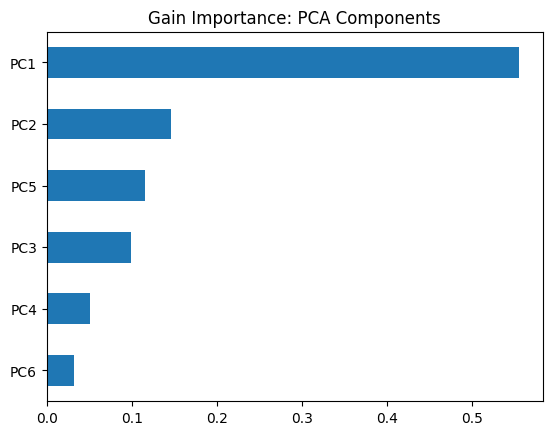

In [9]:
# Get Gain importance for PCA components
print("Gain Importance (PCA Components):")
pca_gain = pd.Series(
    model.feature_importances_, 
    index=[f"PC{i+1}" for i in range(X_train_pca.shape[1])]
)
#print(pca_gain.sort_values(ascending=False))

# Plot
pca_gain.sort_values().plot(kind='barh', title='Gain Importance: PCA Components')
plt.show()

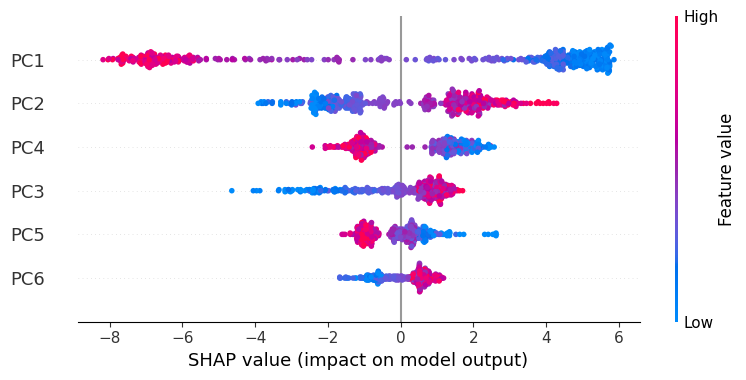

In [ ]:
# SHAP on PCA components
explainer_pca = shap.Explainer(model)
shap_values_pca = explainer_pca(X_train_pca)

# Summary plot
shap.summary_plot(shap_values_pca, X_train_pca, feature_names=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])
#plt.title('SHAP Importance: PCA Components')
plt.show()

#0 - Benign #1 - Malignant
#shap - measure of how much a feature contributes to the overall prediction
#gain - how much a feature improves model accuracy


Gain Importance (Original Features):


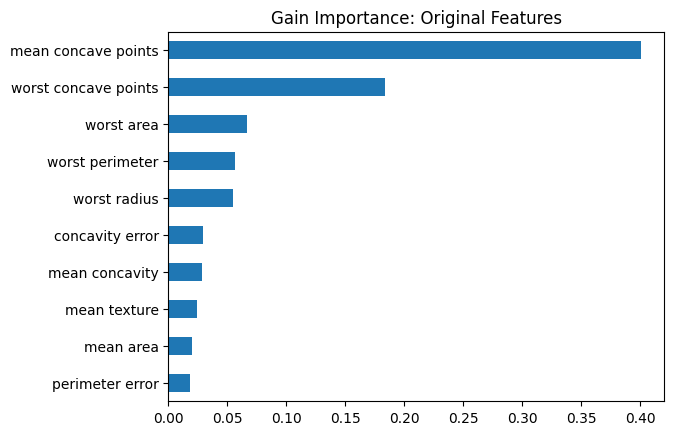

In [11]:
# Get Gain importance for original features
print("\nGain Importance (Original Features):")
original_gain = pd.Series(
    model_original.feature_importances_, 
    index=data.feature_names
)
#print(original_gain.sort_values(ascending=False).head(5))

# Plot top 10
original_gain.sort_values().tail(10).plot(kind='barh', title='Gain Importance: Original Features')
plt.show()

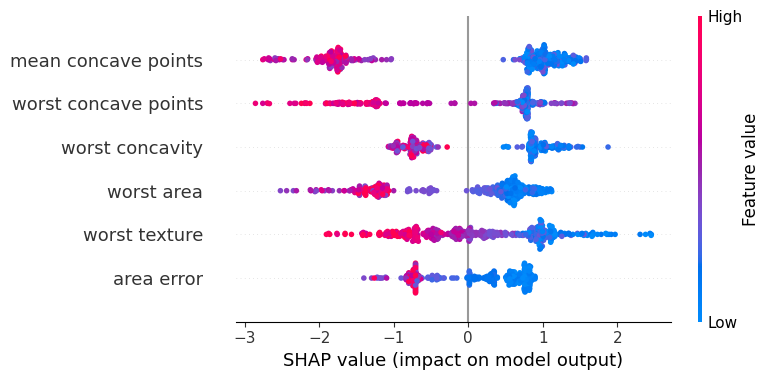

<Figure size 640x480 with 0 Axes>

In [12]:
# Compute SHAP values
explainer_original = shap.Explainer(model_original)
shap_values_original = explainer_original(X_train_scaled)

# Plot only top 6 features
shap.summary_plot(
    shap_values_original, 
    X_train_scaled, 
    feature_names=data.feature_names,
    max_display=6,  # <--- KEY PARAMETER
    plot_type="dot"  # Optional: Use "bar" for global importance, default is "dot" for local+global
)
#plt.title('Top 6 Features by SHAP Importance', pad=20)
plt.tight_layout()  # Prevent title overlap
plt.show()

### Lastly, let's assess the stability of XGBoost models trained on dimension reduced data

In [32]:


def stability_test(model, X_train, y_train, X_test, y_test, feature_names, n_iter=3, noise_scale=0.1):
    """
    Test model stability by adding noise and shuffling data.
    Returns DataFrames of SHAP and Gain importances across iterations.
    """
    shap_results = []
    gain_results = []
    
    for i in range(n_iter):
        # Add Gaussian noise and shuffle
        X_noisy = X_train + np.random.normal(0, noise_scale, size=X_train.shape)
        X_noisy, y_noisy = shuffle(X_noisy, y_train, random_state=i)
        
        # Retrain model
        model_copy = xgb.XGBClassifier(random_state=42)
        model_copy.fit(X_noisy, y_noisy)
        
        # Get Gain importance
        gain = pd.Series(model_copy.feature_importances_, index=feature_names, name=f"Iter_{i}")
        gain_results.append(gain)
        
        # Get SHAP importance
        explainer = shap.Explainer(model_copy)
        shap_values = explainer(X_noisy)
        shap_importance = pd.Series(np.abs(shap_values.values).mean(axis=0), index=feature_names, name=f"Iter_{i}")
        shap_results.append(shap_importance)
    
    return pd.concat(shap_results, axis=1), pd.concat(gain_results, axis=1)

# PCA model (already trained on X_train_pca)
pca_shap_stability, pca_gain_stability = stability_test(
    model, 
    X_train_pca, 
    y_train, 
    X_test_pca, 
    y_test,
    feature_names=[f"PC{i+1}" for i in range(X_train_pca.shape[1])],
    noise_scale=0.2  # Higher noise for PCs (they're already compressed)
)



# Original model (already trained on X_train_scaled)
original_shap_stability, original_gain_stability = stability_test(
    model_original,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    feature_names=data.feature_names,
    noise_scale=0.1
)

print("PCA Model - SHAP Stability (Top 3 PCs):")
print(pca_shap_stability.head(3).T)

print("\nPCA Model - Gain Stability (Top 3 PCs):")
print(pca_gain_stability.head(3).T)

print("\nOriginal Model - SHAP Stability (Top 5 Features):")
print(original_shap_stability.mean(axis=1).sort_values(ascending=False).head(5))


print("\nOriginal Model - Gain Stability (Top 5 Features):")
print(original_gain_stability.mean(axis=1).sort_values(ascending=False).head(5))


#shap - measure of how much a feature contributes to the overall prediction
#gain - how much a feature improves model accuracy

PCA Model - SHAP Stability (Top 3 PCs):
             PC1       PC2       PC3
Iter_0  4.734601  1.533155  0.938977
Iter_1  4.819674  1.695220  0.931112
Iter_2  4.923755  1.783385  1.000650

PCA Model - Gain Stability (Top 3 PCs):
             PC1       PC2       PC3
Iter_0  0.580997  0.127447  0.083865
Iter_1  0.550995  0.127892  0.107100
Iter_2  0.597837  0.125688  0.088713

Original Model - SHAP Stability (Top 5 Features):
worst concave points    1.173788
worst radius            1.042647
mean concave points     0.972604
worst texture           0.779799
worst area              0.718677
dtype: float32

Original Model - Gain Stability (Top 5 Features):
mean concave points     0.208490
worst concave points    0.190368
worst perimeter         0.184052
worst area              0.114172
worst radius            0.088448
dtype: float32


In [33]:


def calculate_stability(importance_dfs):
    """Compute mean Spearman correlation between iterations."""
    corrs = []
    for i in range(len(importance_dfs.columns)):
        #in this case it is 3
        for j in range(i+1, len(importance_dfs.columns)):
            corr, _ = spearmanr(importance_dfs.iloc[:, i], importance_dfs.iloc[:, j])
            corrs.append(corr)
    return np.mean(corrs)

# Compare PCA vs. Original
pca_shap_stability_score = calculate_stability(pca_shap_stability)
original_shap_stability_score = calculate_stability(original_shap_stability)

print(f"\n SHAP Stability Score (PCA): {pca_shap_stability_score:.2f}")
print(f"SHAP Stability Score (Original): {original_shap_stability_score:.2f}")

pca_gain_stability_score = calculate_stability(pca_gain_stability)    
original_gain_stability_score = calculate_stability(original_gain_stability)  

print(f"\n  Gain Stability Score (PCA): {pca_gain_stability_score:.2f}")
print(f"  Gain Stability Score (Original): {original_gain_stability_score:.2f}")




 SHAP Stability Score (PCA): 0.96
SHAP Stability Score (Original): 0.71

  Gain Stability Score (PCA): 0.96
  Gain Stability Score (Original): 0.60


## In conclusion using PCA to reduce the dimensionality of our features not only improves the accuracy of our XGBoost models, it also improves the stability and reproducibility of the model